<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/main/notebooks/NumpyroGaltonBoard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Galton Board simulator from [the mining gold paper](https://github.com/johannbrehmer/simulator-mining-example) but in numpyro.

In [1]:
!pip install --quiet git+https://github.com/Justinezgh/goldmine.git@setup
!pip install --quiet numpyro 

     |████████████████████████████████| 292 kB 5.4 MB/s 


In [2]:
%pylab inline 
import jax 
import jax.numpy as jnp 
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd= tfp.distributions

import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

from goldmine.simulators.galton import GeneralizedGaltonBoard
from goldmine.simulate import simulate, main

Populating the interactive namespace from numpy and matplotlib


First, the simulator from the mining gold paper:

In [8]:
# simulator from mining gold github 

import autograd.numpy as np
import autograd as ag

from goldmine.simulators.base import Simulator
from goldmine.various.functions import sigmoid
from goldmine.various.utils import check_random_state
from tqdm import tqdm

prior = tfd.Uniform(-1, 0)

class GeneralizedGaltonBoard(Simulator):
    """ Generalized Galton board example from arXiv:1805.XXXXX """


    def __init__(self, n_rows=20, n_nails=31):

        super().__init__()

        self.n_rows = n_rows
        self.n_nails = n_nails

        self.d_trace = ag.grad_and_aux(self.trace)  # for mining: calculate the gradient log_p_xz (the joint score)

    def nail_positions(self, theta, level=None, nail=None):

        level_rel = 1. * level / (self.n_rows - 1) #zv
        nail_rel = 2. * nail / (self.n_nails - 1) - 1. #zh

        nail_positions = ((1. - np.sin(np.pi * level_rel)) * 0.5
                          + np.sin(np.pi * level_rel) * sigmoid(10 * theta * nail_rel))

        return nail_positions

    def threshold(self, theta, trace):
        begin, z = trace
        pos = begin
        level = 0
        for step in z:
            if step == 0: # going left
                if level % 2 == 0:
                    pos = pos
                else:
                    pos = pos - 1
            else: # going right
                if level % 2 == 0:
                    pos = pos + 1
                else:
                    pos = pos
            level += 1
        if level % 2 == 1:  # for odd rows, the first and last nails are constant
            if pos == 0:
                return 0.0
            elif pos == self.n_nails:
                return 1.0
        return self.nail_positions(theta, level, pos)

    def trace(self, theta, u, theta_ref=None, score = 'density'):

        # Run and mine gold
        # left/right decisions are based on value of theta_ref (which defaults to theta if None)
        # but log_pxz based on value of theta (needed for ratio)

        if theta_ref is None:
            theta_ref = theta

        begin = pos = self.n_nails // 2
        z = []
        pos_ = [float(pos)]
        log_ = []

        log_p_xz = 0.0

        while len(z) < self.n_rows :
            t_ref = self.threshold(theta_ref, (begin, z))
            t = self.threshold(theta, (begin, z))

            level = len(z)

            # going left
            if u[level] < t_ref or t_ref == 1.0:
                log_p_xz += np.log(t)
                log_.append(float(np.log(t)._value))

                if level % 2 == 0:  # even rows
                    pos = pos
                else:  # odd rows
                    pos = pos - 1

                z.append(0)

            # going right
            else:
                log_p_xz += np.log(1. - t)
                log_.append(float(np.log(1. - t)._value))

                if level % 2 == 0:
                    pos = pos + 1
                else:
                    pos = pos

                z.append(1)
            pos_.append(float(pos))

        x = pos
        log_p_theta = prior.log_prob(jnp.array(theta._value))
        if score == 'density':
          return log_p_xz + log_p_theta , (float(x), pos_, log_)
        if score == 'conditional':
          return log_p_xz , (float(x), pos_, log_) 


    def rvs_score(self,
                  theta, theta_score,
                  n, random_state=None,
                  score = 'density'):

        """ Draws samples x according to p(x|theta), augments them with joint score t(x, z | theta_score) """

        rng = check_random_state(random_state)

        all_x = []
        all_t_xz = []
        all_pos = []
        all_log = []

        for i in tqdm(range(n)):
            u = rng.rand(self.n_rows)

            t_xz, (x, pos, log) = self.d_trace(theta_score, u, theta_ref=theta)

            all_x.append(x)
            all_t_xz.append(t_xz)
            all_pos.append(pos)
            all_log.append(log)

        all_x = np.array(all_x)
        all_t_xz = np.array(all_t_xz)
        all_pos = np.array(all_pos)
        all_log = np.array(all_log)

        return all_x, all_t_xz, all_pos, all_log


    def theta_defaults(self, n_thetas=100, single_theta=False, random=True):
      return np.array([prior.sample(n_thetas, jax.random.PRNGKey(0))]).reshape([-1,1])




#! /usr/bin/env python

# from __future__ import absolute_import, division, print_function

import argparse
import logging
from os import sys, path
import autograd.numpy as np


try:
    from goldmine.various.look_up import create_simulator
    from goldmine.various.utils import general_init, create_missing_folders, get_size
    from goldmine.simulators.base import SimulatorException
except ImportError:
    if base_dir in sys.path:
        raise
    sys.path.append(base_dir)
    from goldmine.various.look_up import create_simulator
    from goldmine.various.utils import general_init, create_missing_folders, get_size
    from goldmine.simulators.base import SimulatorException


def simulate(simulator_name,
             sample_label,
             theta0=None,
             theta1=None,
             draw_from=None,
             single_theta=False,
             grid_sampling=False,
             generate_joint_ratio=True,
             generate_joint_score=True,
             checkpoint=False,
             n_thetas=1000,
             n_samples_per_theta=1000,
             random_state=None,
             continue_after_exceptions=True, 
             score = 'density'):
    """
    Draws sample from a simulator.

    :param continue_after_exceptions:
    :param single_theta:
    :param grid_sampling:
    :param sample_label:
    :param simulator_name: Specifies the simulator. Currently supported are 'galton' and 'epidemiology'.
    :param theta0: None or ndarray that provides a list of theta0 values (the numerator of the likelihood ratio as well
                   as the score reference point). If None, load simulator defaults.
    :param theta1: None or ndarray that provides a list of theta1 values (the denominator of the likelihood ratio) with
                   same shape as theta0. If None, load simulator defaults.
    :param draw_from: list, either [0], [1], or None (= [0,1]). Determines whether theta0, theta1, or both are used for
                      the sampling.
    :param generate_joint_ratio: bool, whether to ask the simulator for the joint ratio (only if theta1 is given).
    :param generate_joint_score: bool, whether to ask the simulator for the joint score.
    :param checkpoint: bool, whether to use a checkpointed version of the simulator.
    :param n_thetas: int, number of thetas samples of theta0 is None and single_theta is False
    :param n_samples_per_theta: Number of samples per combination of theta0 and theta1.
    :param random_state: Numpy random state.
    """

    simulator = GeneralizedGaltonBoard() 


    # Default thetas
    if theta0 is None:
        theta0 = simulator.theta_defaults(single_theta=single_theta,
                                                  n_thetas=n_thetas,
                                                  random=not grid_sampling)

    # Check thetas
    has_theta1 = (theta1 is not None)

    if has_theta1:
        if theta1.shape != theta0.shape:
            raise ValueError('theta0 and theta1 have different shapes: %s, %s', theta0.shape, theta1.shape)
        if draw_from is None:
            draw_from = [0, 1]
        if draw_from not in [[0], [1], [0, 1]]:
            raise ValueError('draw_from has value other than [0], [1], [0,1]: %s', draw_from)

    else:
        theta1 = np.empty_like(theta0)
        theta1[:] = np.NaN

        if generate_joint_ratio:
            logging.warning('Joint ratio requested, but theta1 not given -- will just generate joint score.')
        generate_joint_ratio = False

        if draw_from is None:
            draw_from = [0]
        if draw_from not in [[0]]:
            raise ValueError('No theta1, and draw_from has value other than [0]: %s', draw_from)

    n_samples_per_theta_and_draw = n_samples_per_theta // len(draw_from)

    # Data to be generated
    all_theta0 = []
    all_theta1 = []
    all_x = []
    all_y = []
    all_pos = []
    all_log = []
    all_r_xz = []
    all_t_xz = []
    all_z_checkpoints = []
    all_r_xz_checkpoints = []
    all_t_xz_checkpoints = []

    logging.info('Parameter points:')
    logging.info('  theta0 = %s', theta0)
    if has_theta1:
        logging.info('  theta1 = %s', theta1)

    # Loop over thetas and run simulator
    n_simulations = len(list(zip(theta0, theta1)))
    n_verbose = max(n_simulations // 100, 1)

    for i_simulation, (theta0_, theta1_) in enumerate(zip(theta0, theta1)):


        if (i_simulation + 1) % n_verbose == 0:
            logging.info('Starting simulation for parameter setup %s / %s: theta0 = %s, theta1 = %s', i_simulation + 1,
                         n_simulations, theta0_, theta1_)
        
        for y in draw_from:

            t_xz = None
            r_xz = None
            z_checkpoints = None
            r_xz_checkpoints = None
            t_xz_checkpoints = None

            try:
                if checkpoint and generate_joint_score:
                    x, t_xz, z_checkpoints, t_xz_checkpoints = simulator.rvs_score(
                        theta=theta0_,
                        theta_score=theta0_,
                        n=n_samples_per_theta_and_draw,
                        random_state=random_state,
                        score = score
                    )
                elif generate_joint_score:
                    x, t_xz, pos, log = simulator.rvs_score(
                        theta=theta0_,
                        theta_score=theta0_,
                        n=n_samples_per_theta_and_draw,
                        random_state=random_state,
                        score = score
                    )

                all_theta0 += [theta0_] * n_samples_per_theta_and_draw
                all_theta1 += [theta1_] * n_samples_per_theta_and_draw
                all_x += list(x)
                all_pos += list(pos)
                all_log += list(log)
                all_y += [y] * n_samples_per_theta_and_draw
                if generate_joint_ratio:
                    all_r_xz += list(r_xz)
                if generate_joint_score:
                    all_t_xz += list(t_xz)
                if checkpoint and (generate_joint_ratio or generate_joint_score):
                    all_z_checkpoints += list(z_checkpoints)
                    if generate_joint_ratio:
                        all_r_xz_checkpoints += list(r_xz_checkpoints)
                    if generate_joint_score:
                        all_t_xz_checkpoints += list(t_xz_checkpoints)

            except SimulatorException as e:
                logging.warning('Simulator raised exception: %s', e)

                if continue_after_exceptions:
                    logging.info('Ignoring this parameter point and continuing with others.')
                else:
                    raise

    all_theta0 = np.array(all_theta0)
    all_theta1 = np.array(all_theta1)
    all_x = np.array(all_x)
    all_y = np.array(all_y)
    if generate_joint_ratio:
        all_r_xz = np.array(all_r_xz)
    if generate_joint_score:
        all_t_xz = np.array(all_t_xz)
    if checkpoint and (generate_joint_ratio or generate_joint_score):
        all_z_checkpoints = np.array(all_z_checkpoints)
        if generate_joint_ratio:
            all_r_xz_checkpoints = np.array(all_r_xz_checkpoints)
        if generate_joint_score:
            all_t_xz_checkpoints = np.array(all_t_xz_checkpoints)


    return all_theta0, all_x, all_t_xz, all_pos, all_log

Same simulator using numpyro: 

In [4]:
# numpyro version 

import numpyro
import jax
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist
import jax.numpy as jnp
from numpyro.contrib.control_flow import cond

def sigmoid_(x):
    return 1. / (1. + jnp.exp(-x))

def nail_positions(theta, n_rows, n_nails, level, nail):

    level_rel = 1. * level / (n_rows - 1) #zv
    nail_rel = 2. * nail / (n_nails - 1) - 1. #zh

    nail_positions = ((1. - jnp.sin(jnp.pi * level_rel)) * 0.5
                      + jnp.sin(jnp.pi * level_rel) * sigmoid_(10 * theta * nail_rel))
    
    res = cond(level % 2 == 1 and nail == 0, 
                       lambda _: 0.0, 
                       lambda _: cond(level % 2 == 1 and nail == n_nails, 
                                                 lambda _: 1.0, 
                                                 lambda _: nail_positions, 
                                                 0), 
                       0)

    return nail_positions

def galton_board(y = None,  n_rows = 20, n_nails = 31):

  theta = numpyro.sample('theta', dist.Uniform(-1, 0))
  pos = n_nails // 2

  for level in range(n_rows):
    # z = numpyro.sample('z%d' %level, dist.Bernoulli(1 - nail_positions(theta, n_rows, n_nails, level, pos)))
    # pos = z - (level % 2) + pos
    # print('level : ', level, '__pos :', pos, 'right :', jnp.log(1 - nail_positions(theta, n_rows, n_nails, level, pos)), 'left :', jnp.log(nail_positions(theta, n_rows, n_nails, level, pos)))
    
    pos = numpyro.sample('z%d' %level,  
                      dist.TransformedDistribution(dist.Bernoulli(1 - nail_positions(theta, n_rows, n_nails, level, pos)), 
                                              dist.transforms.AffineTransform( - (level % 2) + pos, 1)))
    
  y = numpyro.sample("y", 
                      dist.TransformedDistribution(dist.Bernoulli(1 - nail_positions(theta, n_rows, n_nails, level, pos)), 
                                              dist.transforms.AffineTransform( - (level % 2) + pos, 1)), 
                      obs=y)

  return y

Numpyro simulator check:

In [11]:
theta_0 = -0.8
theta_1 = -0.6

n_nails=31
n_rows=20

In [12]:
galton_rvs  = lambda theta :GeneralizedGaltonBoard().rvs_score(theta, theta, n=20000, random_state=1234)

samples_0, score_0, pos_0, log_0 = galton_rvs(theta_0)
p_estimated_0, _ = np.histogram(samples_0, bins=n_nails, range=(0, n_nails), density=True)

samples_1, score_1, pos_1, log_1 = galton_rvs(theta_1)
p_estimated_1, _ = np.histogram(samples_1, bins=n_nails, range=(0, n_nails), density=True)

100%|██████████| 20000/20000 [02:55<00:00, 114.04it/s]


In [13]:
key = jax.random.PRNGKey(200)
keys = jax.random.split(key, 20000)

cond_model0 = condition(galton_board, {'theta': -0.8})
x0 = jax.vmap(lambda k: trace(seed(cond_model0, k)).get_trace()['y']['value'])(keys)

cond_model1 = condition(galton_board, {'theta': -0.6})
x1 = jax.vmap(lambda k: trace(seed(cond_model1, k)).get_trace()['y']['value'])(keys)

In [14]:
p_estimated_0_numpyro, _ = np.histogram(x0, bins=31, range=(0, 31), density=True)
p_estimated_1_numpyro, _ = np.histogram(x1, bins=31, range=(0, 31), density=True)

Text(0.5, 1.0, 'check numpyro simulator')

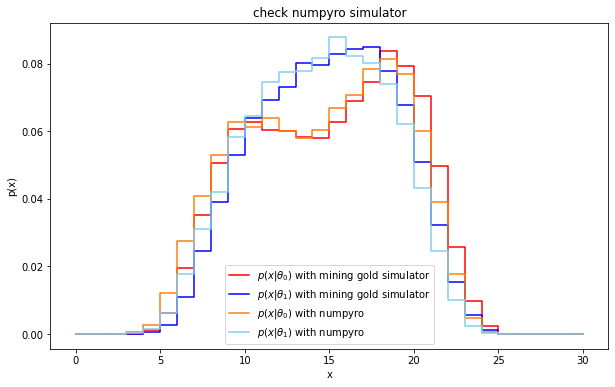

In [15]:
figure(figsize=(10,6))

plt.step(range(len(p_estimated_0)), p_estimated_0,
         c='r', lw=1.5,
         label=r'$p(x|\theta_0)$ with mining gold simulator')

plt.step(range(len(p_estimated_0)), p_estimated_1,
         c='b', lw=1.5, 
         label=r'$p(x|\theta_1)$ with mining gold simulator')

plt.step(range(len(p_estimated_0_numpyro)), p_estimated_0_numpyro,
         c='C1', lw=1.5,
         label=r'$p(x|\theta_0)$ with numpyro')

plt.step(range(len(p_estimated_1_numpyro)), p_estimated_1_numpyro,
         c='skyblue', lw=1.5, 
         label=r'$p(x|\theta_1)$ with numpyro ')

plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend()
plt.title('check numpyro simulator')

In [5]:
from numpyro.handlers import seed, trace, condition
import jax

def get_samples_and_scores(model, key, batch_size=64, score_type='density', thetas=None):
  
    def log_prob_fn(theta, key):

        cond_model = condition(model, {'theta': theta})
        cond_model = seed(cond_model, key)
        model_trace = trace(cond_model).get_trace()

        if score_type == 'density':
            logp = model_trace['theta']['fn'].log_prob(model_trace['theta']['value'])
        elif score_type == 'conditional':
            logp = 0

        for i in range(1, len(model_trace)): 
          key, val = list(model_trace.items())[i]
          logp += val['fn'].log_prob(val['value'])

        sample = {'theta': model_trace['theta']['value'],
                  'y': model_trace['y']['value']}
    
        return logp, sample

    
    # Split the key by batch
    keys = jax.random.split(key, batch_size)

    # Sample theta from the model
    if thetas == None:
        thetas = jax.vmap(lambda k: trace(seed(model, k)).get_trace()['theta']['value'])(keys)

    return jax.vmap(jax.value_and_grad(log_prob_fn, has_aux=True))(thetas, keys)

In [6]:
@jax.jit
def get_batch(key, batch_size=int(5e3)):
    model = galton_board
    (log_probs, samples), scores = get_samples_and_scores(model, key, batch_size=batch_size)
    return samples['theta'], samples['y'], scores

mu, batch, grad = get_batch(jax.random.PRNGKey(62))

In [ ]:
t_, x_, score0___, pos0, log0 = simulate(simulator_name = 'galton',
            sample_label = 'train', 
            theta0=None,
            single_theta=True, 
            generate_joint_ratio=False,
            generate_joint_score=True,
            n_thetas=5e3,
            n_samples_per_theta=1, 
            score = 'density')

Text(0.5, 1.0, 'check gradients of numpyro simulator')

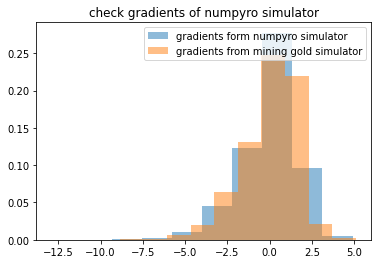

In [10]:
plt.hist(grad, alpha = 0.5, density = True, label = 'gradients form numpyro simulator');
plt.hist(score0___.squeeze(), alpha = 0.5, density = True, label = 'gradients from mining gold simulator');
plt.legend()
plt.title('check gradients of numpyro simulator')